# New case studies for Robot Dance paper

In [6]:
import os
import pandas as pd
import numpy as np
import datetime

import run_robot
import prepare_data
from importlib import reload
reload(prepare_data)
reload(run_robot)

Loading PyJulia module...
Loading PyJulia module... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!
Loading modules...
Loading modules... Ok!
Loading Julia library...
Loading Julia library... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!


<module 'run_robot' from '/home/pjssilva/documentos/pesquisa/robot_dance/code/run_robot.py'>

In [7]:
# Define the basic data for the case studies

# Compute initial values for first run and read the cities and other initial data
ndays = 14*2*14 # 180 + 2*14
basic_prm = prepare_data.save_basic_parameters(min_level=0.8, rep=2.0, ndays=30)

# Compute initial values and read mobility matrix

# For cities
# cities_data = prepare_data.compute_initial_condition_evolve_and_save(basic_prm, "SP", ["Araçatuba", "São José Do Rio Preto"], 500000, 1)
# cities_data = prepare_data.compute_initial_condition_evolve_and_save(basic_prm, "SP", ["São José Do Rio Preto"], 25000, 6, 1)
# M = prepare_data.convert_mobility_matrix_and_save(cities_data, max_neighbors=3, drs=False)

# For DRS
subnot_factor = 11.6
cities_data = prepare_data.compute_initial_condition_evolve_and_save(basic_prm, "SP", [], 1, subnot_factor, 1, "data/covid_with_drs.csv")
M = prepare_data.convert_mobility_matrix_and_save(cities_data, max_neighbors=5, drs=True)


1/22 Araraquara                     Mean effective R in the last two weeks = 1.06
2/22 Araçatuba                      Mean effective R in the last two weeks = 0.82
3/22 Baixada Santista               Mean effective R in the last two weeks = 0.83
4/22 Barretos                       Mean effective R in the last two weeks = 1.17
5/22 Bauru                          Mean effective R in the last two weeks = 0.93
6/22 Campinas                       Mean effective R in the last two weeks = 0.94
7/22 Franca                         Mean effective R in the last two weeks = 1.10
8/22 Marília                        Mean effective R in the last two weeks = 0.98
9/22 Mun. São Paulo                 Mean effective R in the last two weeks = 1.17
10/22 Piracicaba                     Mean effective R in the last two weeks = 0.83
11/22 Presidente Prudente            Mean effective R in the last two weeks = 1.01
12/22 Registro                       Mean effective R in the last two weeks = 0.75
13/22 Ribeir

In [8]:
cities_data = pd.read_csv("data/cities_data.csv", index_col=0)

# Create a target matrix (max infected level)
ncities, ndays = len(cities_data.index), int(basic_prm["ndays"])
target = np.ones((ncities, ndays))
target = prepare_data.save_target(cities_data, target)
hammer_data = prepare_data.save_hammer_data(cities_data, 0, 0.8)

# Use a forcedif that releases the cities in the end
force_dif = np.ones((ncities, ndays))
cities_data

,S1,E1,I1,R1,population,icu_capacity
Araraquara,0.882645,0.012446,0.006780,0.098129,991435.0,0.000150
Araçatuba,0.830087,0.012724,0.007589,0.149599,764041.0,0.000172
Baixada Santista,0.705301,0.012934,0.008020,0.273744,1831884.0,0.000259
Barretos,0.794936,0.025331,0.013303,0.166429,425090.0,0.000174
Bauru,0.843546,0.013216,0.007554,0.135684,1741281.0,0.000126
Campinas,0.780174,0.017204,0.009772,0.192851,4562125.0,0.000208
Franca,0.894883,0.013420,0.007327,0.084371,691672.0,0.000121
Marília,0.911614,0.008021,0.004503,0.075862,1109670.0,0.000151
Mun. São Paulo,0.745442,0.017451,0.008830,0.228277,11869660.0,0.000302
Piracicaba,0.787802,0.014364,0.008539,0.189295,1539600.0,0.000178


## Case 1: 14 day window, official data

In [9]:
verbosity = 2
basic_prm["alternate"] = 0.0
run_robot.find_feasible_hammer(basic_prm, cities_data, M, target, hammer_data, None, incr_all=True, save_file=False, verbosity=verbosity)

Checking if initial hammer is long enough...
Time to simulate: 0.57
Araraquara violates number of infected after 0 days of hammer (level 0.8): Infected 0.0003 (target 0.00011271540746493719)
Araçatuba violates number of infected after 0 days of hammer (level 0.8): Infected 0.00033 (target 0.00012887724611637333)
Baixada Santista violates number of infected after 0 days of hammer (level 0.8): Infected 0.00034 (target 0.0001945292387509253)
Barretos violates number of infected after 0 days of hammer (level 0.8): Infected 0.0006 (target 0.0001305605871697758)
Bauru violates number of infected after 0 days of hammer (level 0.8): Infected 0.00033 (target 9.438740789108707e-05)
Campinas violates number of infected after 0 days of hammer (level 0.8): Infected 0.00043 (target 0.00015620023563580566)
Franca violates number of infected after 0 days of hammer (level 0.8): Infected 0.00033 (target 9.078591369683602e-05)
Marília violates number of infected after 0 days of hammer (level 0.8): Infect

Solving Robot-dance...
Solving Robot-dance... Ok!
Total tests used 174.26970657832288

-----
Number of rt changes in each city
Araraquara: 23
Araçatuba: 18
Baixada Santista: 8
Barretos: 14
Bauru: 24
Campinas: 13
Franca: 26
Marília: 25
Mun. São Paulo: 9
Piracicaba: 15
Presidente Prudente: 26
Registro: 17
Ribeirão Preto: 12
Sorocaba: 27
Sub região leste - RMSP: 18
Sub região norte - RMSP: 17
Sub região oeste - RMSP: 15
Sub região sudeste - RMSP: 8
Sub região sudoeste - RMSP: 24
São José do Rio Preto: 8
São João da Boa Vista: 22
Taubaté: 17
-----

-----
Average fraction of infected
Araraquara: 0.003327506132081404
Araçatuba: 0.0032363832503767946
Baixada Santista: 0.0025799230057728106
Barretos: 0.0031096306557210104
Bauru: 0.0028615539114784268
Campinas: 0.0031813928140117893
Franca: 0.0028061485796451176
Marília: 0.0033113890664373726
Mun. São Paulo: 0.0035973382140343573
Piracicaba: 0.002998378265473385
Presidente Prudente: 0.0023264384180307577
Registro: 0.0027415102089917535
Ribeirão

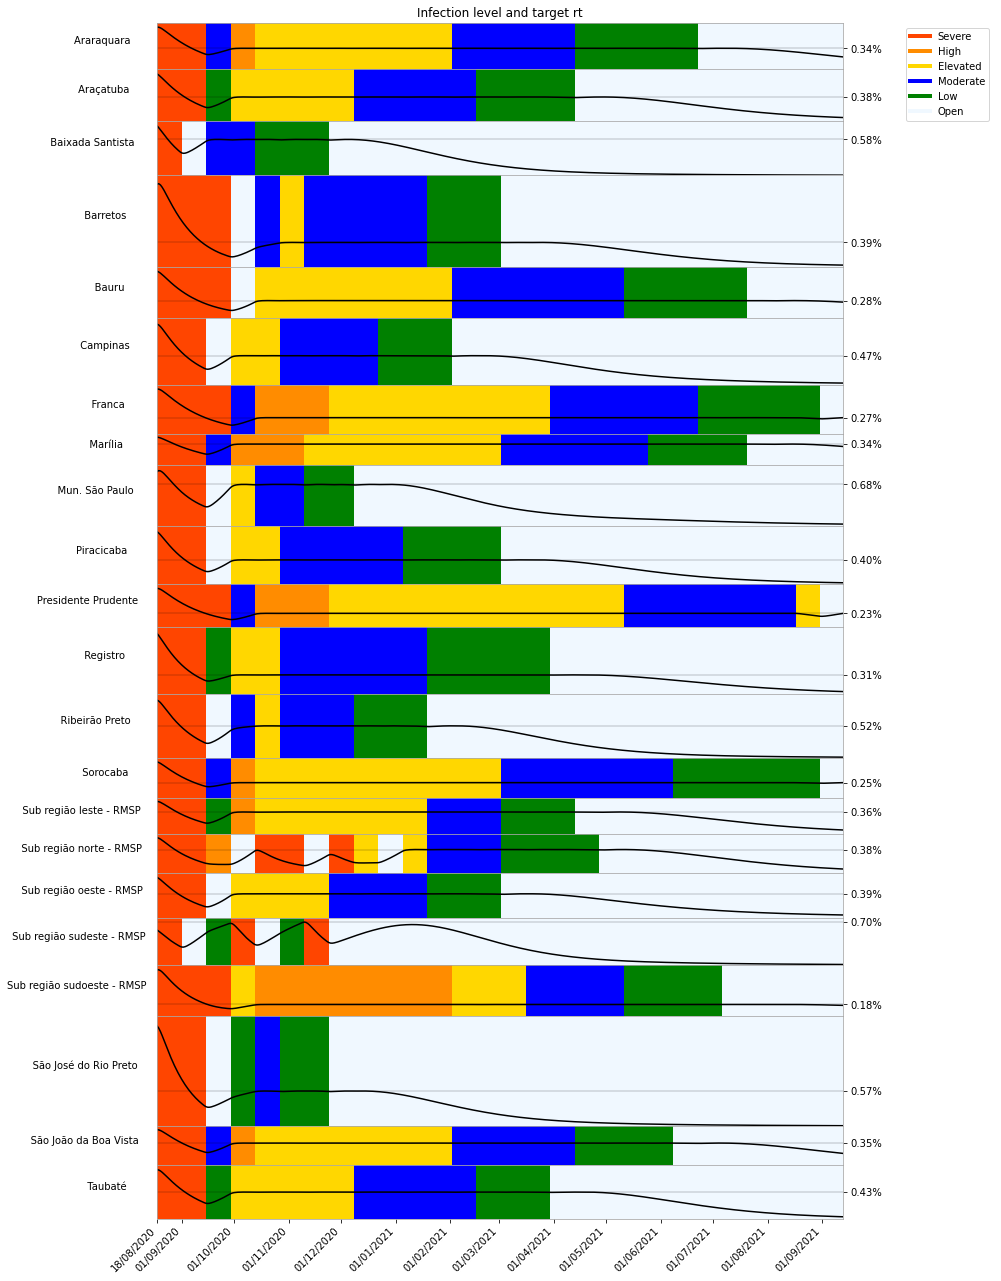

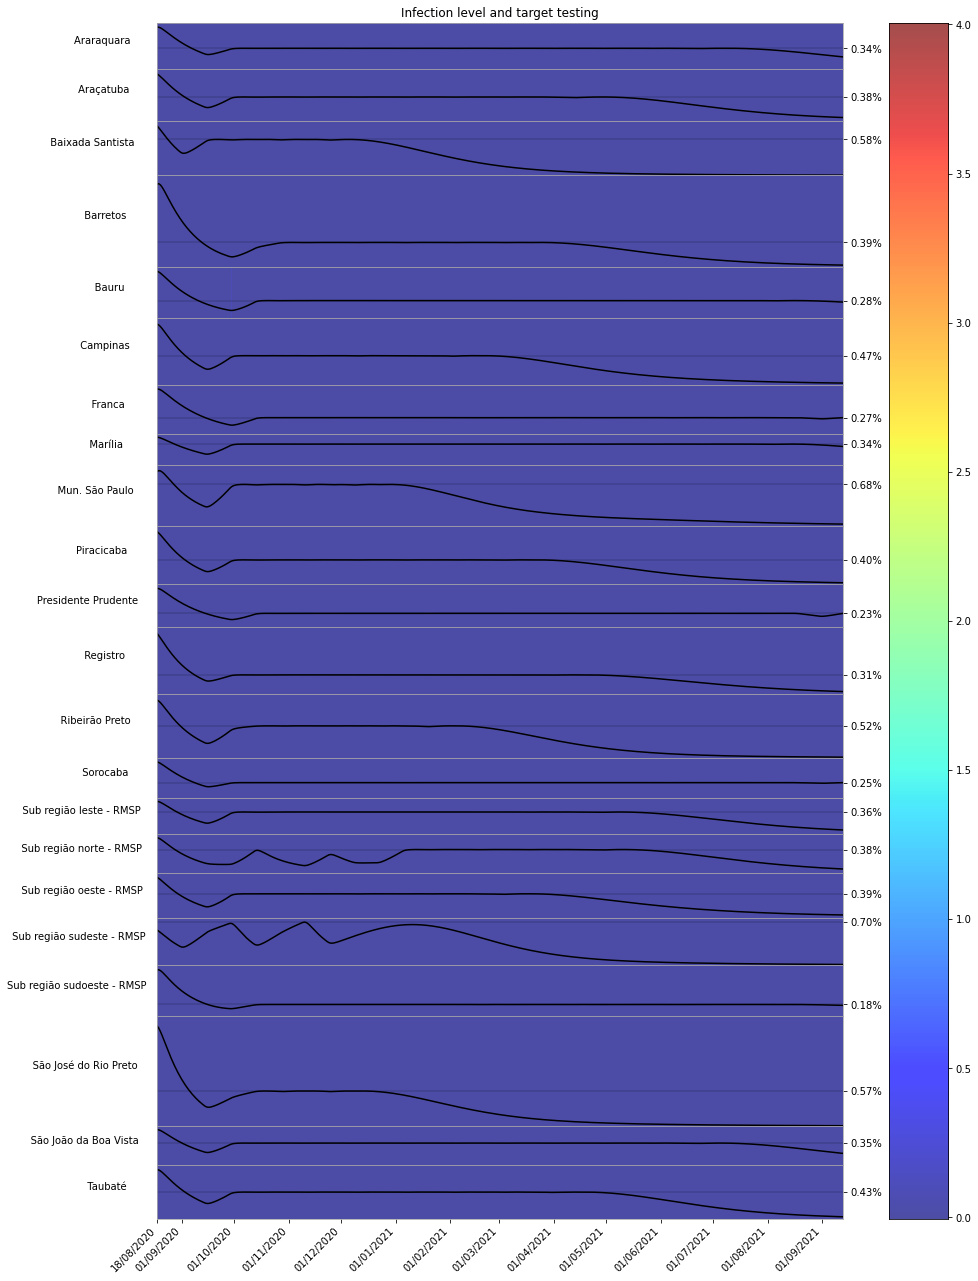

In [10]:
%%time

base_output_name = "results/tests_connected_{:d}_daily_unlimited"
budgets = [0] #[0, 1500000, 5000000, 20000000, 50000000]
for budget in budgets:
    output_name = base_output_name.format(budget)
    run_robot.prepare_optimization(basic_prm, cities_data, M, target, hammer_data, force_dif, verbosity=verbosity, test_budget=budget)
    run_robot.optimize_and_show_results(basic_prm, output_name + ".png", output_name + ".csv", 
                                        cities_data, start_date="2020-08-18", verbosity=verbosity)